# Book Data EDA

In this notebook I will do EDA on data from the [book crossing dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). The dataset features info about books rated on https://www.bookcrossing.com/ and is broken into three tables: Books, Users and Ratings. Each table is related by the ISBN number for each book. 

In [173]:
# data munging
import numpy as np
import pandas as pd
import sqlite3

# eda/viz
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

## Importing book data

In [98]:
!ls data/BX-CSV-Dump

BX-Book-Ratings.csv BX-Books.csv        BX-Users.csv


In [99]:
books = pd.read_csv('data/BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

users = pd.read_csv('data/BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('data/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/Users/max/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/i

## Exploration and cleaning
### Books Data

In [100]:
print(books.shape)
books.head(3)

(271360, 8)


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


Three entries have entries that are off by a column. Dropping these three records. 

In [101]:
# filtering for non-ints in yearOfPublication

books.drop(books[pd.to_numeric(books.yearOfPublication, errors='coerce').isnull()].index, inplace=True)

In [102]:
# changing all to int type and finding min/max
books.yearOfPublication = books.yearOfPublication.astype(int)

print(books.yearOfPublication.min())
print(books.yearOfPublication.max())

0
2050


Many books are published in the future or have 0 as their pub date. Time to remove those. This data was scraped in 2004 so nothing should have been published after that year. 

In [103]:
books.drop(books[books.yearOfPublication == 0].index, inplace=True)
books.drop(books[books.yearOfPublication > 2004].index, inplace=True)

print(books.yearOfPublication.min())
print(books.yearOfPublication.max())

1376
2004


In [104]:
books[books.yearOfPublication < 1900]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
171817,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable...",Benjamin Franklin,1806,Reprint Services Corp,http://images.amazon.com/images/P/0781228956.0...,http://images.amazon.com/images/P/0781228956.0...,http://images.amazon.com/images/P/0781228956.0...
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...
245607,0781268001,"Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...",Silas Weir Mitchell,1897,Reprint Services Corp,http://images.amazon.com/images/P/0781268001.0...,http://images.amazon.com/images/P/0781268001.0...,http://images.amazon.com/images/P/0781268001.0...
253750,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...


The book published in 1376 and 1378 and 1806 appear to have been a mistake, so I will remove that record. This will  make the publishing year distribution a bit more normal (althought still quite skewed).

In [105]:
books.drop(books[books.yearOfPublication <1896].index, inplace=True)

print(books.yearOfPublication.min())

1897


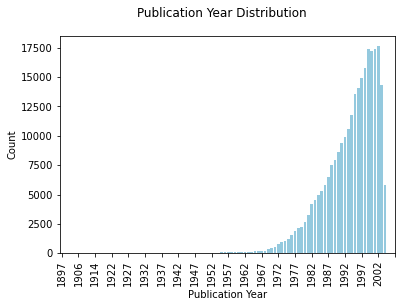

In [169]:
sns.countplot(books.yearOfPublication, color='skyblue')
plt.xticks([year for year in range(0, 105, 5)], rotation=90)
plt.suptitle('Publication Year Distribution')
plt.xlabel('Publication Year')
plt.ylabel('Count')
plt.savefig('viz/pub_year_dist.png');

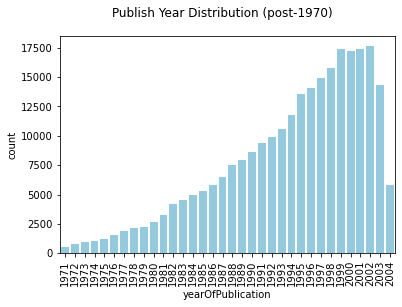

In [107]:
# detail of just recent books 

sns.countplot(books[books.yearOfPublication > 1970].yearOfPublication, color='skyblue')
plt.xticks(rotation=90)
plt.suptitle('Publish Year Distribution (post-1970)');

### Users Data

In [108]:
print(users.shape)
users.head(3)

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [109]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userID    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Missing age data for ~100k users. Consider whether or not age will matter for collaborative recommendation. 

Text(0.5, 0.98, 'User Age Distribution (Raw)')

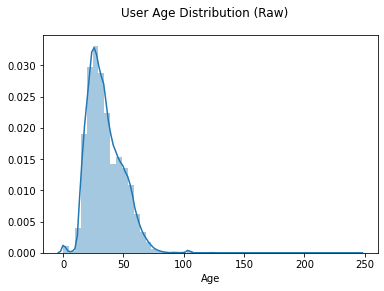

In [110]:
sns.distplot(users.Age)
plt.suptitle('User Age Distribution (Raw)')

Plotting age distribution shows there are some incorrectly entered user ages. Will have to remove low and high ages when cleaning. 

In [111]:
# users under age 10

users[users.Age < 15].groupby('Age').count()

,userID,Location
Age,,
0.0,416,416
1.0,288,288
2.0,105,105
3.0,45,45
4.0,28,28
5.0,26,26
6.0,18,18
7.0,27,27
8.0,54,54


In [112]:
# users over age 100
users[users.Age > 99].groupby('Age').count()

,userID,Location
Age,,
100.0,7,7
101.0,7,7
102.0,3,3
103.0,56,56
104.0,192,192
...,...,...
230.0,1,1
231.0,1,1
237.0,1,1


I'll drop ages under 13, since that's where there appears to be a dramatic drop off in reviews, and that also passes a sanity test of how old the youngest readers are likely to be. Since ages trickle in consistently over all but go all the way to over 200, I will cap age at 99 because there a spike in reviews between 100-105, and I believe that to be an erorr, considering it is fairly unlikely there is a group of very tech savvy centurions reviewing books online in the early 2000s. 

In [113]:
users.drop(users[users.Age > 99].index, inplace=True)
users.drop(users[users.Age < 13].index, inplace=True)

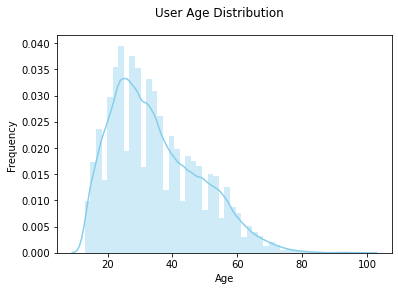

In [170]:
# clean
sns.distplot(users.Age, color='skyblue')
plt.suptitle('User Age Distribution')
plt.ylabel('Frequency')
plt.savefig('viz/user_age_dist.png')

### Ratings Data

In [115]:
print(ratings.shape)
ratings.head(3)

(1149780, 3)


,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [116]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [117]:
ratings.bookRating.describe()

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: bookRating, dtype: float64

In [118]:
ratings[ratings.bookRating > 0].bookRating.describe()

count    433671.000000
mean          7.601066
std           1.843798
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: bookRating, dtype: float64

No nulls for all books that have been rated.

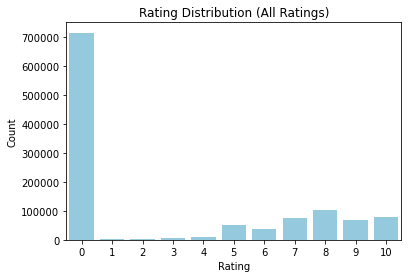

In [119]:
sns.countplot(ratings.bookRating, color='skyblue')
plt.title('Rating Distribution (All Ratings)')
plt.xlabel('Rating')
plt.ylabel('Count');

0 on this scale means that the book was not rated. It's clear from this viz that the vast majority of books weren't rated. (from the [note from [data source](http://www2.informatik.uni-freiburg.de/~cziegler/BX/): "Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0."

In [120]:
print('"0" Ratings:   ', ratings[ratings.bookRating == 0].bookRating.count(), '>>>', round(ratings[ratings.bookRating == 0].bookRating.count() / ratings.bookRating.count() * 100), '%')
print('"1-10" Ragints:', ratings[ratings.bookRating > 0].bookRating.count(), '>>>', round(ratings[ratings.bookRating > 0].bookRating.count() / ratings.bookRating.count() * 100), '%')

"0" Ratings:    716109 >>> 62 %
"1-10" Ragints: 433671 >>> 38 %


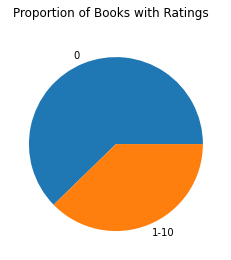

In [121]:
rating_proportion_list = [ratings[ratings.bookRating == 0].bookRating.count(), ratings[ratings.bookRating > 0].bookRating.count()]

plt.pie(rating_proportion_list, labels=['0', '1-10'])
plt.suptitle('Proportion of Books with Ratings');

Text(0, 0.5, 'Count')

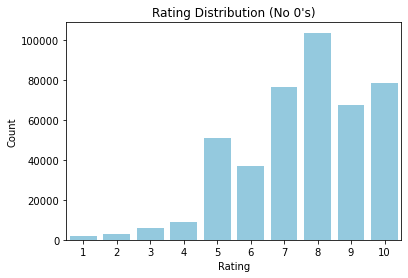

In [122]:
sns.countplot(ratings.bookRating[ratings.bookRating > 0], color='skyblue')
plt.title('Rating Distribution (No 0\'s)')
plt.xlabel('Rating')
plt.ylabel('Count')

In [123]:
ratings.sort_values(by='userID')

,userID,ISBN,bookRating
9561,2,0195153448,0
9562,7,034542252,0
9572,8,0771025661,0
9580,8,1881320189,7
9579,8,1575663937,6
...,...,...,...
9560,278854,0553579606,8
9554,278854,0375703063,7
9553,278854,0316184152,7
9555,278854,042516098X,7


In [124]:
# removing 0 scores (not rated)

ratings = ratings[ratings.bookRating >0]

In [125]:
ratings.shape

(433671, 3)

## Diving deeper into the data
### User-level

Number of users

In [126]:
len(users)

277019

Reviews per user

In [127]:
ratings.groupby('userID').count().sort_values(by='bookRating', ascending=False)

,ISBN,bookRating
userID,,
11676,8524,8524
98391,5802,5802
153662,1969,1969
189835,1906,1906
23902,1395,1395
...,...,...
84129,1,1
165812,1,1
34231,1,1


Mean, std, quartiles of number of reviews per user

In [128]:
ratings.groupby('userID').count().describe()

,ISBN,bookRating
count,77805.000000,77805.000000
mean,5.573819,5.573819
std,44.001879,44.001879
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,3.000000
max,8524.000000,8524.000000


In [129]:
ratings[ratings.userID==11676]

,userID,ISBN,bookRating
45326,11676,9022906116,7
45327,11676,"\0432534220\""""",6
45328,11676,"\2842053052\""""",7
45330,11676,0=965044153,7
45331,11676,0000000000,9
...,...,...,...
58921,11676,O439060737,10
58922,11676,O446611638,7
58925,11676,O9088446X,8
58926,11676,X000000000,10


This user rated over 8000 books. That is far more than the average person could read in a lifetime. I will drop users who have over 1900 reviews to preserve the integrity of user profiles for when I do collaborative filtering later. 

In [130]:
user_rating_counts = ratings['userID'].value_counts()
user_rating_counts

11676     8524
98391     5802
153662    1969
189835    1906
23902     1395
          ... 
232692       1
181469       1
193755       1
171222       1
20086        1
Name: userID, Length: 77805, dtype: int64

In [131]:
# removing users who have reviewed over 1900 books (too many, must be an error)
ratings = ratings[ratings['userID'].isin(user_rating_counts[user_rating_counts < 1400].index)]
ratings.shape

(415470, 3)

In [132]:
# removing users who have reviewed less than 5 books
ratings = ratings[ratings['userID'].isin(user_rating_counts[user_rating_counts >= 5].index)]
ratings.shape

(322140, 3)

In [133]:
book_rating_counts = ratings['ISBN'].value_counts()

In [134]:
# removing books that have been reviewed less than 5 times
ratings = ratings[ratings['ISBN'].isin(book_rating_counts[book_rating_counts >= 5].index)]
ratings.shape

(134299, 3)

Removing books with less than 20 ratings and users with 20 <= ratings < 1900 cuts the total number of rated book down from 433671 to 190854 (~50%)

In [135]:
user_rating_counts

11676     8524
98391     5802
153662    1969
189835    1906
23902     1395
          ... 
232692       1
181469       1
193755       1
171222       1
20086        1
Name: userID, Length: 77805, dtype: int64

In [136]:
ratings.describe()

,userID,bookRating
count,134299.000000,134299.000000
mean,139332.772113,7.783558
std,80006.933340,1.779236
min,8.000000,1.000000
25%,70594.000000,7.000000
50%,136396.000000,8.000000
75%,209833.000000,9.000000
max,278854.000000,10.000000


Text(0.5, 0, 'Number of reviews')

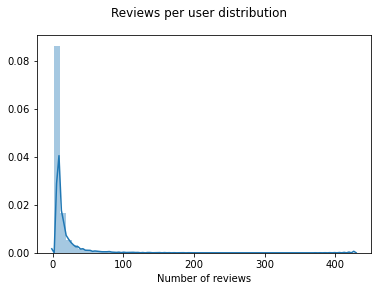

In [137]:
sns.distplot(ratings.groupby('userID').count().sort_values(by='bookRating', ascending=False).ISBN)
plt.suptitle('Reviews per user distribution')
plt.xlabel('Number of reviews')

In [138]:
ratings.groupby('userID').count().sort_values(by='bookRating', ascending=False)

,ISBN,bookRating
userID,,
16795,427,427
95359,374,374
114368,368,368
104636,301,301
123883,276,276
...,...,...
95336,1,1
95915,1,1
96168,1,1


## Book-level

In [139]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [140]:
# quantity ratings per book, in order of most to least rated

ratings.groupby('ISBN').count().sort_values(by='bookRating', ascending=False)

,userID,bookRating
ISBN,,
0316666343,436,436
0385504209,337,337
0971880107,269,269
0312195516,244,244
059035342X,225,225
...,...,...
0743211995,5,5
0743212576,5,5
0743213165,5,5


In [141]:
# describing quanity of ratings per book

ratings.groupby('ISBN').bookRating.count().describe()

count    10592.000000
mean        12.679286
std         16.660664
min          5.000000
25%          6.000000
50%          8.000000
75%         13.000000
max        436.000000
Name: bookRating, dtype: float64

Most books are only rated once or twice, but some are rated several hundred times.

<AxesSubplot:>

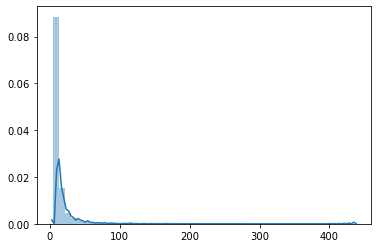

In [142]:
sns.distplot(ratings.groupby('ISBN').count())

## Final prep and analysis

In [143]:
# average rating across all books

ratings['bookRating'].mean()

7.7835575841964575

In [144]:
rating_counts = ratings['bookRating'].value_counts().sort_index()
rating_counts

1       403
2       733
3      1521
4      2283
5     12936
6     10269
7     22791
8     33054
9     23593
10    26716
Name: bookRating, dtype: int64

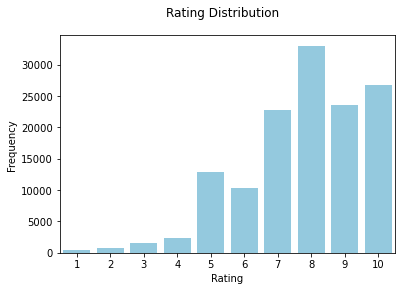

In [167]:
sns.barplot(rating_counts.index, rating_counts, color='skyblue')
plt.suptitle('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.savefig('viz/rating_dist.png')

In [146]:
books.shape

(266664, 8)

In [147]:
ratings.ISBN

16         0060517794
19         0671537458
20         0679776818
133        0060096195
137        0375821813
              ...    
1149739    0743202694
1149743    0836218655
1149744    0836236688
1149761    0345386108
1149771    0743211383
Name: ISBN, Length: 134299, dtype: object

In [148]:
# df with only books included in the cleaned ratings table to cut down on size
# and compare size to see how many books were removed (166k)
rated_books = books[books['ISBN'].isin(ratings['ISBN'])]

In [149]:
# no duplicates

rated_books.ISBN.value_counts().max()

1

In [150]:
rated_books.shape

(10077, 8)

In [151]:
users.shape

(277019, 3)

In [152]:
users_clean = users[users['userID'].isin(ratings['userID'])]
users_clean.shape

(12854, 3)

#### Pickling files

In [183]:
pd.to_pickle(rated_books, "data/rated_books_clean.pkl")

In [184]:
pd.to_pickle(books, "data/all_books_clean.pkl")

In [185]:
pd.to_pickle(ratings, "data/ratings_clean.pkl")

In [186]:
pd.to_pickle(users_clean, "data/users_clean.pkl")

#### Exporting clean dfs to csv

In [153]:
rated_books.to_csv('data/rated_books_clean.csv', index=False)

In [154]:
books.to_csv('data/all_books_clean.csv', index=False)

In [155]:
ratings.to_csv('data/ratings_clean.csv', index=False)

In [156]:
users_clean.to_csv('data/users_clean.csv', index=False)

In [158]:
books.shape

(266664, 8)

In [160]:
rated_books.shape

(10077, 8)